In [ ]:
#https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdataimport matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [183]:
url = 'https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv'

raw_dataset = pd.read_csv(url)

c:\users\jeffr\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [184]:
#make a copy of the original dataset

dataset = raw_dataset.copy()

In [185]:
#remove any columns whose datatype is not a float64 or int64, as well as the imputation flags. Keep only variables which correlate with KWH

end_reached = False

for col in dataset.columns:

  if end_reached:
    dataset.pop(col)

  elif col[0] == 'Z' or dataset[col].dtype == 'object':
    dataset.pop(col)

  elif dataset[col].dtype == 'int64' and np.abs(pearsonr(dataset['KWH'], dataset[col])[0]) < 0.3:
    dataset.pop(col)
  
  elif col == 'KWH':
    end_reached = True

c:\users\jeffr\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [187]:
#split the data into training and testing sets

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('KWH')
test_labels = test_features.pop('KWH')

In [188]:
#normalize the variables

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [189]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [190]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [191]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=300,
    verbose=0,
    validation_split = 0.2)

Wall time: 57.3 s


In [221]:
#storing information about the model's progress

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [193]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([4000, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [KWH]')
  plt.legend()
  plt.grid(True)

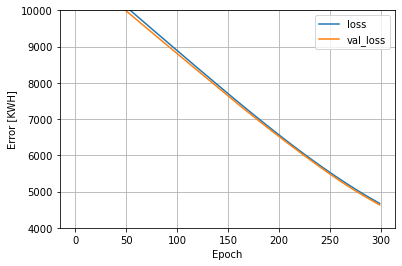

In [194]:
plot_loss(history)

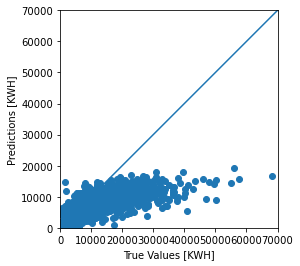

In [220]:
test_predictions = linear_model.predict(test_features)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [KWH]')
plt.ylabel('Predictions [KWH]')
lims = [0, 70000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
'''This data was analyzed using linear regression with multiple inputs. First, to simplify the analysis, variables which were not sufficiently 
correlated with the target variable (KWH) were discarded. This correlation was measured using Pearson's correlation coefficient. Variables of object
type were also ignored so as to simplify the model. In addition, parameters such as cost of electricity which occur after the target are omitted 
since they are directly related and cannot be measured without knowing the power consumption beforehand. The data is then split into a training set
which comprises 80% of the original dataset, and a testing set the remainder. The linear model is then set up with a mean absolute error loss function.
For validation, the accuracy of the model is tested on 20% of the original training data. After training the model over 300 epochs, the loss and 
validation loss functions are seen to be approximately equal. Finally, the values for KWH predicted by the model are compared with those in the testing
set, and we see that the model tends to underestimate the variable as it increases in size. This suggests that a simple linear model may not be 
sophisticated enough to predict power consumption over a wide range of values.'''